In [1]:
import glob
import h5py
import numpy as np
from torch.utils.data import *
from collections.abc import Iterable
from data_utils import *
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from vq_unet_model import VQ_Unet

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


## Define Dataset

In [2]:
root = '/home/featurize/data/Generate_Data_Step_0_496_264_20020601_20190409.mat'
train_dataset = MyDataset(root, mode='train', in_channels=26, out_channels=4, steps=1)
valid_dataset = MyDataset(root, mode='valid', in_channels=26, out_channels=4, steps=1)

In [3]:
batch_size = 4
device = 'cuda'
folder_to_save_models = 'weights_32-32_epoch100'

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=6, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=6, shuffle=False)

In [4]:
model = VQ_Unet(in_channels=26,out_channels=4)

## Training

In [5]:
logger = TensorBoardLogger("log", name="version-16-4")

In [6]:
trainer = pl.Trainer(gpus=1, callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')], logger=logger)

/home/featurize/work/.local/lib/python3.7/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type        | Params
------------------------------------------
0  | enc1     | DenseBlock  | 299 K 
1  | enc2     | Sequential  | 763 K 
2  | enc3     | Sequential  | 1.4 M 
3  | enc4     | Sequential  | 1.6 M 
4  | enc5     | Sequential  | 1.6 M 
5  | enc6     | Sequential  | 1.6 M 
6  | enc7     | Sequential  | 1.6 M 
7  | enc8     | Sequential  | 1.6 M 
8  | bridge   | Sequential  | 147 K 
9  | codebook | VQEmbedding | 65.5 K
10 | dec8     | Sequential  | 147 K 
11 | dec7_1   | UpConvBlock | 147 K 
12 | dec7_2   | Sequential  | 295 K 
13 | dec6_1   | UpConvBlock | 147 K 
14 | dec6_2   | Sequential  | 295 K 
15 | dec5_1   | UpConvBlock | 147 K 
16 | dec5_2   | Sequential  | 295 K 
17 | dec4_1   | UpConvBlock | 147 K 
18 | dec4_2   | Sequential  | 295 K 
19 | dec3_1   | UpConvBlock | 147 K 
20 | dec3_2   | Sequential  | 295 K 
21 | dec2_1   | UpConvBlock | 147 K 
22 | dec2_2   | Sequential  | 258 K 
23 | dec1_1   | UpConvBloc

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Testing

In [8]:
# checkpoint = '/home/featurize/work/SST-Forecast/vq-unet/log/version1/version_0/checkpoints/epoch=40-step=6273.ckpt'
# model = VQ_Unet.load_from_checkpoint(checkpoint, in_channels=32,out_channels=8)

In [35]:
x, y = next(iter(val_loader))
model.eval()
preds = model(x)

In [36]:
# print(x.shape, y.shape)
# preds, targets = learn.get_preds(2)
pred_idx = 3
pred = preds[0][pred_idx].cpu().detach().numpy()
print(pred.shape)

(4, 264, 496)


In [37]:
label = y[pred_idx].cpu().detach().numpy()
print(label.shape)

(4, 264, 496)


In [38]:
input = x[0].cpu().detach().numpy()

In [39]:
pred = recover(pred, 17., 32.)
label = recover(label, 17., 32.)
input = recover(input, 17., 32.)

In [40]:
print(pred[:,0,0])
print(label[:,0,0])

[24.142284 23.747911 23.900581 23.108273]
[24.675  24.8575 24.65   24.73  ]


In [41]:
diff = abs(pred - label)
print(diff)

[[[5.3271484e-01 6.2726593e-01 4.8806763e-01 ... 1.2157440e-01
   1.7337799e-01 2.3481369e-01]
  [2.7525139e-01 3.3969498e-01 2.3481750e-01 ... 6.5734863e-02
   1.4842415e-01 2.9408455e-01]
  [3.0942535e-01 1.0101318e-02 4.1509628e-02 ... 7.2902679e-02
   1.5110779e-01 2.0567703e-01]
  ...
  [2.1423149e-01 7.4548721e-02 7.7098846e-02 ... 3.7353706e-01
   6.1068535e-01 1.1102676e-02]
  [6.5532684e-02 7.0432663e-02 8.7167740e-02 ... 2.4175072e-01
   4.9187469e-01 3.2460403e-01]
  [2.3389435e-01 2.5850296e-01 2.8055000e-01 ... 2.8470993e-01
   1.6724205e-01 1.3039551e+00]]

 [[1.1095886e+00 5.6761169e-01 6.3601112e-01 ... 2.5106812e-01
   3.2249832e-01 9.4647217e-01]
  [4.4227409e-01 4.5688248e-01 4.5839691e-01 ... 2.4942207e-01
   3.0226517e-01 4.7167206e-01]
  [4.2187500e-01 3.8022614e-01 4.3358421e-01 ... 3.1846809e-01
   4.5453835e-01 4.7910500e-01]
  ...
  [1.9813728e-01 3.7743378e-01 1.9137573e-01 ... 2.5312424e-02
   1.6686821e-01 5.9318542e-04]
  [3.4576607e-01 2.9673386e-01 2.907

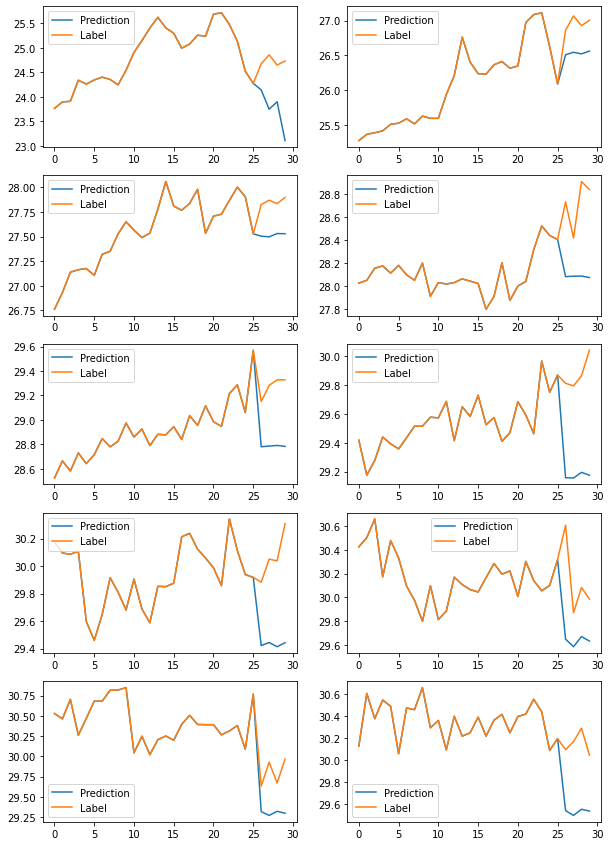

In [42]:
# idx = [100, 250]
plt.figure(figsize=(10,15))
for idx in range(10):
    i = idx*15
    plt.subplot(5,2,idx+1)
    plt.plot(np.concatenate([input[...,i, i], pred[...,i, i]]))
    plt.plot(np.concatenate([input[...,i, i],label[...,i, i]]))
    plt.legend(['Prediction', 'Label'])

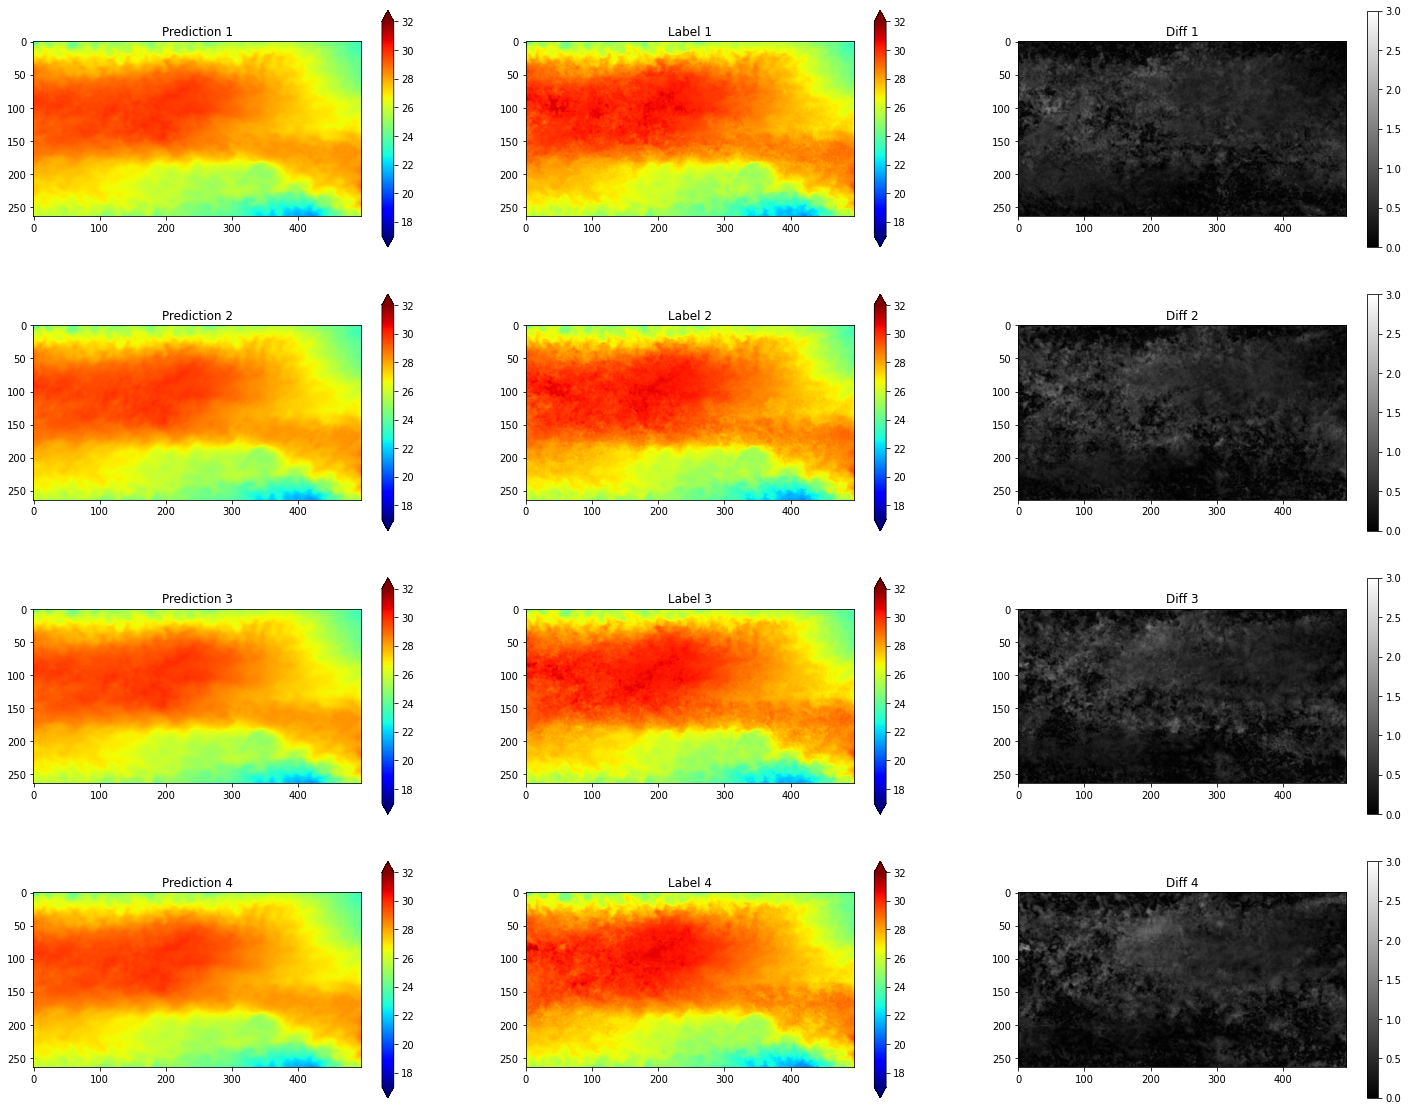

In [43]:
plt.figure(figsize=(25,20))
len = pred.shape[0]
for i in range(len):
    plt.subplot(len, 3, i*3+1)
    plt.imshow(pred[i], cmap='jet', vmax=32, vmin=17)
    plt.title('Prediction {}'.format(i+1))
    plt.colorbar(extend='both')
    plt.subplot(len, 3, i*3+2)
    plt.imshow(label[i], cmap='jet', vmax=32, vmin=17)
    plt.title('Label {}'.format(i+1))
    plt.colorbar(extend='both')
    plt.subplot(len, 3, i*3+3)
    plt.imshow(diff[i], cmap='gray', vmin=0, vmax=3)
    plt.title('Diff {}'.format(i+1))
    plt.colorbar()
